<a href="https://colab.research.google.com/github/naisargi1101/Buffer-Overflow-Detection/blob/main/Buffer_Overflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/juliet_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/juliet_dataset')

In [ ]:
import os
import csv

# Define the label mapping dictionary
label_mapping = {
    "CWE121_Stack_Based_Buffer_Overflow": "Stack-based Buffer Overflow",
    "CWE122_Heap_Based_Buffer_Overflow": "Heap-based Buffer Overflow",
    "CWE124_Buffer_Underwrite": "Buffer Underwrite",
    "CWE126_Buffer_Overread": "Buffer Overread",
    "CWE127_Buffer_Underread": "Buffer Underread",
    "CWE190_Integer_Overflow": "Integer Overflow",
    "CWE191_Integer_Underflow": "Integer Underflow",
    "CWE761_Free_Pointer_Not_at_Start_of_Buffer": "Free of Pointer – not at Start of Buffer"
}

# Define the output file path
output_file_path = '/content/drive/MyDrive/Juliet_input_dataset.csv'

# Open the output file in write mode
with open(output_file_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['code', 'label'])
    count = 0
    # Traverse the directory tree and process each file
    for root, dirs, files in os.walk('/content/juliet_dataset/testcases'):
        # Check if the current directory is a bug type directory
        directory_name = os.path.basename(root)
        if directory_name in label_mapping:
            label = label_mapping[directory_name]
            for file in files:
                # Read the contents of the file
                with open(os.path.join(root, file), 'r', encoding='utf-8', errors='ignore') as f:
                    code = f.read().replace('\n', ' ~')
                writer.writerow([code, label])
        else:
            # If the directory is not a bug type directory, label it as "Not prone to overflow type vulnerability"
            for file in files:
                if count<=10:
                  # Read the contents of the file
                  with open(os.path.join(root, file), 'r', encoding='utf-8', errors='ignore') as f:
                      code = f.read().replace('\n', ' ~')
                  writer.writerow([code, 'Not prone to overflow type vulnerability'])
                  count += 1
                else:
                  count = 0
                  break


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Juliet_input_dataset.csv')
print(df.head(4))


                                                code  \
0  /* TEMPLATE GENERATED TESTCASE FILE ~Filename:...   
1  /* TEMPLATE GENERATED TESTCASE FILE ~Filename:...   
2  /* TEMPLATE GENERATED TESTCASE FILE ~Filename:...   
3  /* TEMPLATE GENERATED TESTCASE FILE ~Filename:...   

                                      label  
0  Not prone to overflow type vulnerability  
1  Not prone to overflow type vulnerability  
2  Not prone to overflow type vulnerability  
3  Not prone to overflow type vulnerability  


In [ ]:
import re

def remove_comments_and_nonascii(text):
    # Remove comments (single-line and multi-line)
    text = re.sub(r"(\".*?\"|\'.*?\')|(/\*.*?\*/|//[^\r\n]*$)", "", text, flags=re.DOTALL|re.MULTILINE)
    
    # Remove non-ASCII characters
    text = text.encode("ascii", "ignore").decode()
    return text


In [ ]:
import pandas as pd

#df = pd.read_csv("/content/drive/MyDrive/output.csv")
df["code"] = df["code"].apply(remove_comments_and_nonascii)
#df.to_csv("output_cleaned.csv", index=False)
df.head(4)


,code,label
0,~ ~ ~#include ~ ~#ifndef OMITBAD ~ ~void CWE...,Not prone to overflow type vulnerability
1,~ ~ ~#include ~ ~#ifdef _WIN32 ~# include <w...,Not prone to overflow type vulnerability
2,~ ~ ~#include ~ ~#define CHAR_ARRAY_SIZE (3 ...,Not prone to overflow type vulnerability
3,~ ~ ~#include ~ ~ ~static const int static_c...,Not prone to overflow type vulnerability


In [ ]:
df.shape

(34634, 2)

In [ ]:
df['label'].value_counts()

Heap-based Buffer Overflow                  9028
Stack-based Buffer Overflow                 8001
Integer Overflow                            4163
Buffer Underread                            3287
Buffer Underwrite                           3287
Integer Underflow                           2546
Buffer Overread                             2273
Not prone to overflow type vulnerability    1144
Free of Pointer – not at Start of Buffer     905
Name: label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataframe into training and testing datasets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42,stratify=df['label'])

# Save the datasets to your Google Drive
train_df.to_csv('/content/drive/MyDrive/train_data.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/test_data.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(train_df.shape)

(27707, 2)


In [ ]:
import os

# Define sensitive functions
S = {"strcpy", "strcat", "gets", "fscanf", "vscanf", "vsscanf", "vfscanf", "vsprintf", "getopt", "getpass", "strecpy", "strncat", "strtrns", "sprint", "scanf", "sscanf", "strcmp", "strncmp", "strncpy", "strlwr", "strtok", "strset", "strstr", "strchr", "strrchr", "strerror", "strupr", "strrev", "streadd", "realpath", "strsep"}

# Define function to extract critical code slices using Slicef algorithm
def slicef(code):
    code = str(code)
    D = set()
    current_code = code.split('~')
    fun_count = 0
    for line in current_code:
        line = line.strip()
        # Check for logic control code in current line
        if ("if" in line or "else" in line or "while" in line or "for" in line) and line not in D:
            D.add(line)
        # Check for sensitive functions in current line
        for s in S:
            if s in line:
                # Check if line contains parameters
                if '(' in line:
                    parameters = line[line.index("(")+1:line.index(")")]
                    param_list = parameters.split(',')
                    new_params = []
                    for param in param_list:
                        new_params.append('fun' + str(fun_count))
                        fun_count += 1
                    new_line = line.replace(parameters, ','.join(new_params))
                    if s in new_line and new_line not in D:
                        new_line = new_line.replace(s, 'fun' + str(fun_count))
                        fun_count += 1
                        D.add(new_line)
                # Check if line does not contain parameters
                else:
                    if line not in D:
                        D.add(line)
    return D

#train_df = pd.read_csv('/content/output_cleaned.csv')
train_df['internal_feature_set'] = train_df['code'].apply(slicef)
#train_df.to_csv('train_internal_feature.csv', index=False)


In [ ]:
train_df.head(10)

,code,label,internal_feature_set
10289,~rem NOTE: this batch file is to be run in a ...,Integer Underflow,{}
30512,~ ~ ~#include ~ ~#ifndef OMITBAD ~ ~ ~void C...,Integer Overflow,"{#ifndef OMITBAD, #ifdef INCLUDEMAIN, #endif, ..."
23472,~ ~ ~#include ~ ~#include <wchar.h> ~ ~#ifnd...,Stack-based Buffer Overflow,"{#ifndef OMITBAD, #ifdef INCLUDEMAIN, #endif, ..."
28348,~ ~ ~#include ~ ~#define CHAR_ARRAY_SIZE (3 ...,Integer Overflow,"{#endif, CWE190_Integer_Overflow__int_ffun5_sq..."
33503,~ ~ ~#include ~ ~#include <wchar.h> ~ ~names...,Buffer Underwrite,"{#endif, else, #ifndef OMITBAD, #ifndef OMITGO..."
30260,~ ~ ~#include ~ ~#include <math.h> ~ ~extern...,Integer Overflow,"{#endif, else, extern unsigned int CWE190_Inte..."
29271,~ ~ ~#include ~ ~#ifndef OMITBAD ~ ~ ~void C...,Integer Overflow,"{#ifndef OMITBAD, #ifdef INCLUDEMAIN, #endif, ..."
8887,~ ~ ~#include ~ ~# include <wchar.h> ~ ~#ifn...,Heap-based Buffer Overflow,"{#endif, else, if(5!=5), #ifndef OMITBAD, if(5..."
934,~ ~ ~#include ~ ~#include <wchar.h> ~ ~#ifnd...,Heap-based Buffer Overflow,"{#ifndef OMITBAD, #ifdef INCLUDEMAIN, #endif, ..."
25119,~ ~ ~#include ~ ~#ifndef OMITBAD ~ ~void CWE...,Stack-based Buffer Overflow,"{#endif, for (i = 0; i < 100; i++), #ifndef OM..."


In [ ]:
import re
import math
# Define a function to calculate cyclomatic complexity
def calculate_cyclomatic_complexity(code,flag):
    # Count the number of nodes and edges in the control flow graph
    num_nodes = len(re.findall(r'\bif\b|\belse\b|\bfor\b|\bwhile\b|\bcase\b|\bswitch\b|\bcatch\b', code))
    num_edges = len(re.findall(r'\bif\b|\belse\b|\bfor\b|\bwhile\b|\bcase\b|\bswitch\b|\bcatch\b|\breturn\b|\bthrow\b', code))
    num_components = 1 if num_edges >= num_nodes else num_nodes - num_edges + 1
    # calculate CyclomaticStrict
    if flag:
      return num_nodes + num_edges - 2
    # Calculate cyclomatic complexity
    return num_edges - num_nodes + 2 * num_components

# Define a function to extract the features from the code
def extract_features(code):
    # Initialize feature dictionary
    features = {}
    # Split the code into lines
    code = str(code)
    lines = code.split('~')
    # Calculate features
    features['AltCountLineCode'] = sum(1 for line in lines if not line.startswith('//') and not line.startswith('#') and not line.isspace())
    features['AltCountLineComment'] = sum(1 for line in lines if line.startswith('//') or line.startswith('#'))
    features['CountInput'] = len(re.findall(r'\binput\b', code))
    features['CountLine'] = len(lines)
    features['CountLineCode'] = sum(1 for line in lines if not line.startswith('//') and not line.startswith('#') and not line.isspace())
    features['CountLineCodeDecl'] = sum(1 for line in lines if re.search(r'\b(class|struct)\b', line))
    features['CountLineCodeExe'] = features['CountLineCode'] - features['CountLineCodeDecl']
    features['CountLineComment'] = sum(1 for line in lines if line.startswith('//') or line.startswith('#'))
    features['CountLinePreprocessor'] = sum(1 for line in lines if line.startswith('#'))
    features['CountOutput'] = len(re.findall(r'\boutput\b', code))
    features['CountPath'] = calculate_cyclomatic_complexity(code,False)
    features['CountPathLog'] = math.log(features['CountPath'])
    features['CountSemicolon'] = code.count(';')
    features['CountStmt'] = len(re.findall(r'\b(if|else|for|while|do|switch|case|return|throw|try|catch)\b', code))
    features['CountStmtDecl'] = len(re.findall(r'\b(class|struct)\b', code))
    features['CountStmtExe'] = features['CountStmt'] - features['CountStmtDecl']
    features['Cyclomatic'] = calculate_cyclomatic_complexity(code,False)
    features['CyclomaticModified'] = len(re.findall(r'\bif\b|\belse\b|\bfor\b|\bwhile\b|\bcase\b|\bswitch\b|\bcatch\b', code)) + 1
    features['CyclomaticStrict'] = calculate_cyclomatic_complexity(code,True)
    features['Essential'] = features['CountStmt'] - features['CountSemicolon'] + 2
    features['Knots'] = features['CountPath'] - features['Essential'] + 2
    features['MaxEssentialKnots'] = features['CountStmt'] - features['CountSemicolon'] + 1
    return features

#df = pd.read_csv('/content/train_internal_feature.csv')
train_df['external_feature_set'] = train_df['code'].apply(extract_features)
#train_df.to_csv('train_feature.csv', index=False)

In [ ]:
train_df.head(10)

,code,label,internal_feature_set,external_feature_set
10289,~rem NOTE: this batch file is to be run in a ...,Integer Underflow,{},"{'AltCountLineCode': 11, 'AltCountLineComment'..."
30512,~ ~ ~#include ~ ~#ifndef OMITBAD ~ ~ ~void C...,Integer Overflow,"{#ifndef OMITBAD, #ifdef INCLUDEMAIN, #endif, ...","{'AltCountLineCode': 41, 'AltCountLineComment'..."
23472,~ ~ ~#include ~ ~#include <wchar.h> ~ ~#ifnd...,Stack-based Buffer Overflow,"{#ifndef OMITBAD, #ifdef INCLUDEMAIN, #endif, ...","{'AltCountLineCode': 36, 'AltCountLineComment'..."
28348,~ ~ ~#include ~ ~#define CHAR_ARRAY_SIZE (3 ...,Integer Overflow,"{#endif, CWE190_Integer_Overflow__int_ffun5_sq...","{'AltCountLineCode': 16, 'AltCountLineComment'..."
33503,~ ~ ~#include ~ ~#include <wchar.h> ~ ~names...,Buffer Underwrite,"{#endif, else, #ifndef OMITBAD, #ifndef OMITGO...","{'AltCountLineCode': 72, 'AltCountLineComment'..."
30260,~ ~ ~#include ~ ~#include <math.h> ~ ~extern...,Integer Overflow,"{#endif, else, extern unsigned int CWE190_Inte...","{'AltCountLineCode': 33, 'AltCountLineComment'..."
29271,~ ~ ~#include ~ ~#ifndef OMITBAD ~ ~ ~void C...,Integer Overflow,"{#ifndef OMITBAD, #ifdef INCLUDEMAIN, #endif, ...","{'AltCountLineCode': 41, 'AltCountLineComment'..."
8887,~ ~ ~#include ~ ~# include <wchar.h> ~ ~#ifn...,Heap-based Buffer Overflow,"{#endif, else, if(5!=5), #ifndef OMITBAD, if(5...","{'AltCountLineCode': 234, 'AltCountLineComment..."
934,~ ~ ~#include ~ ~#include <wchar.h> ~ ~#ifnd...,Heap-based Buffer Overflow,"{#ifndef OMITBAD, #ifdef INCLUDEMAIN, #endif, ...","{'AltCountLineCode': 34, 'AltCountLineComment'..."
25119,~ ~ ~#include ~ ~#ifndef OMITBAD ~ ~void CWE...,Stack-based Buffer Overflow,"{#endif, for (i = 0; i < 100; i++), #ifndef OM...","{'AltCountLineCode': 74, 'AltCountLineComment'..."


In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import re
# Load the dataset
#df = pd.read_csv('/content/train_feature.csv')
def embedding_layer_fun(temp_df):
    # Convert internal features to list of lists
    internal_features = [list(s) for s in temp_df['internal_feature_set']]

    # Train Word2Vec model on internal features
    model = Word2Vec(internal_features, vector_size=100, window=5, min_count=1, workers=4)


    # Define the radius for context words
    radius = 3

    # Define the dimensions for internal and external embeddings
    internal_dims = 100
    external_dims = 50

    # Load the internal and external feature sets
    ifs_df = temp_df
    efs_df = temp_df

    # Perform word segmentation on internal feature set
    ifs_df['segmented'] = ifs_df['internal_feature_set'].apply(lambda x: [word for word in x if word in model.wv.key_to_index])

    # Vectorize the segmented words using CBOW model
    ifs_df['vectors'] = ifs_df['segmented'].apply(lambda x: np.mean(model.wv[[w for w in x if w in model.wv.key_to_index]], axis=0) 
                                                  if any(w in model.wv.key_to_index for w in x) 
                                                  else np.zeros(model.vector_size))

    # Create the internal embedding layer
    internal_embedding = np.array(ifs_df['vectors'].tolist())
    internal_embedding = np.pad(internal_embedding, ((0, 0), (0, internal_dims - internal_embedding.shape[1])), 'constant')


    # Perform vector transformation on external feature set
    efs_vectors = []
    for i, row in efs_df.iterrows():
        tokens = re.findall(r'\w+', str(row['external_feature_set']))
        vector_list = []
        for j in range(len(tokens)):
            context = tokens[max(j-radius,0):j] + tokens[j+1:min(j+radius+1,len(tokens))]
            vector = np.zeros(model.vector_size)
            if any(w in model.wv.key_to_index for w in context):
                vector = np.mean(model.wv[[w for w in context if w in model.wv.key_to_index]], axis=0)
            vector_list.append(vector)
        efs_vectors.append(vector_list)


    # Create the external embedding layer
    external_embedding = np.array(efs_vectors)
    external_embedding = external_embedding.reshape(efs_df.shape[0], -1)
    external_dims = external_embedding.shape[1]
    external_embedding = np.pad(external_embedding, ((0, 0), (0, external_dims - external_embedding.shape[1])), 'constant')

    # Concatenate internal and external embedding layers
    embedding_layer = np.concatenate((internal_embedding, external_embedding), axis=1)
    return embedding_layer
embedding_layer = embedding_layer_fun(train_df)

In [ ]:
print(embedding_layer)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.29068458  0.53642339 -0.60703635 ...  0.          0.
   0.        ]
 [-0.29068458  0.53642339 -0.60703635 ...  0.          0.
   0.        ]
 ...
 [-0.20125018  0.33763164 -0.40286806 ...  0.          0.
   0.        ]
 [-0.22764328  0.34522724 -0.22111468 ...  0.          0.
   0.        ]
 [-0.30095315  0.55227083 -0.58074278 ...  0.          0.
   0.        ]]


In [ ]:
print(embedding_layer.shape)

(27707, 4600)


In [ ]:
conversion = {'Not prone to overflow type vulnerability':0,
       'Stack-based Buffer Overflow':1, 'Heap-based Buffer Overflow':2,
       'Buffer Overread':3, 'Buffer Underwrite':4, 'Integer Underflow':5,
       'Integer Overflow':6, 'Free of Pointer – not at Start of Buffer':7,
       'Buffer Underread':8}

Labels = []
for i in train_df['label']:
    Labels.append(conversion[i])


In [ ]:
train_df['Label'] = Labels

In [ ]:
train_df

,code,label,internal_feature_set,external_feature_set,segmented,vectors,Label
10289,~rem NOTE: this batch file is to be run in a ...,Integer Underflow,{},"{'AltCountLineCode': 11, 'AltCountLineComment'...",[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
30512,~ ~ ~#include ~ ~#ifndef OMITBAD ~ ~ ~void C...,Integer Overflow,"{#ifndef OMITBAD, #ifdef INCLUDEMAIN, #endif, ...","{'AltCountLineCode': 41, 'AltCountLineComment'...","[#ifndef OMITBAD, #ifdef INCLUDEMAIN, #endif, ...","[-0.29068458, 0.5364234, -0.60703635, -0.51640...",6
23472,~ ~ ~#include ~ ~#include <wchar.h> ~ ~#ifnd...,Stack-based Buffer Overflow,"{#ifndef OMITBAD, #ifdef INCLUDEMAIN, #endif, ...","{'AltCountLineCode': 36, 'AltCountLineComment'...","[#ifndef OMITBAD, #ifdef INCLUDEMAIN, #endif, ...","[-0.29068458, 0.5364234, -0.60703635, -0.51640...",1
28348,~ ~ ~#include ~ ~#define CHAR_ARRAY_SIZE (3 ...,Integer Overflow,"{#endif, CWE190_Integer_Overflow__int_ffun5_sq...","{'AltCountLineCode': 16, 'AltCountLineComment'...","[#endif, CWE190_Integer_Overflow__int_ffun5_sq...","[-0.07707573, 0.15268975, -0.15483455, -0.1560...",6
33503,~ ~ ~#include ~ ~#include <wchar.h> ~ ~names...,Buffer Underwrite,"{#endif, else, #ifndef OMITBAD, #ifndef OMITGO...","{'AltCountLineCode': 72, 'AltCountLineComment'...","[#endif, else, #ifndef OMITBAD, #ifndef OMITGO...","[-0.26759946, 0.3510863, -0.46710798, -0.34507...",4
...,...,...,...,...,...,...,...
25336,~ ~ ~#include ~ ~#define CHAR_ARRAY_SIZE (3 ...,Stack-based Buffer Overflow,"{if (data >= 0 && data < (10)), else, #endif, ...","{'AltCountLineCode': 324, 'AltCountLineComment...","[if (data >= 0 && data < (10)), else, #endif, ...","[-0.2487431, 0.12626982, -0.2398942, -0.394670...",1
13103,~ ~ ~#include ~ ~#include <wchar.h> ~ ~#ifnd...,Buffer Overread,"{#ifndef OMITBAD, #ifdef INCLUDEMAIN, #endif, ...","{'AltCountLineCode': 54, 'AltCountLineComment'...","[#ifndef OMITBAD, #ifdef INCLUDEMAIN, #endif, ...","[-0.29068458, 0.5364234, -0.60703635, -0.51640...",3
19941,~ ~ ~#include ~ ~#ifndef OMITBAD ~ ~ ~extern...,Stack-based Buffer Overflow,"{#endif, else, if(CWE121_Stack_Based_Buffer_Ov...","{'AltCountLineCode': 40, 'AltCountLineComment'...","[#endif, else, if(CWE121_Stack_Based_Buffer_Ov...","[-0.20125018, 0.33763164, -0.40286806, -0.3012...",1
29376,~ ~ ~#include ~ ~#ifdef _WIN32 ~# include <w...,Integer Overflow,"{#endif, else, while (0);, if(data > 0), if(st...","{'AltCountLineCode': 331, 'AltCountLineComment...","[#endif, else, while (0);, if(data > 0), if(st...","[-0.22764328, 0.34522724, -0.22111468, -0.7931...",6


In [ ]:
from keras.layers import Dense,Dropout,GRU,Bidirectional
from keras.models import Sequential
from keras.optimizers import SGD
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(embedding_layer.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(embedding_layer.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(embedding_layer.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(embedding_layer,train_df['Label'],epochs=10,batch_size=150)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
185/185 [==============================] - 116s 590ms/step - loss: 5.8779
Epoch 2/10
185/185 [==============================] - 106s 573ms/step - loss: 5.6354
Epoch 3/10
185/185 [==============================] - 106s 573ms/step - loss: 5.6332
Epoch 4/10
185/185 [==============================] - 106s 573ms/step - loss: 5.6349
Epoch 5/10
185/185 [==============================] - 106s 573ms/step - loss: 5.6253
Epoch 6/10
185/185 [==============================] - 106s 574ms/step - loss: 5.6237
Epoch 7/10
185/185 [==============================] - 106s 573ms/step - loss: 5.6248
Epoch 8/10
185/185 [==============================] - 106s 573ms/step - loss: 5.6227
Epoch 9/10
185/185 [==============================] - 106s 574ms/step - loss: 5.6201
Epoch 10/10
185/185 [==============================] - 106s 573ms/step - loss: 5.6181


In [ ]:
test_df.head(5)

,code,label
16780,~ ~ ~#include ~ ~#include <wchar.h> ~ ~#ifnd...,Buffer Underread
11190,~ ~#ifndef OMITGOOD ~ ~#include ~#include ~...,Integer Underflow
2000,~ ~ ~#include ~ ~namespace CWE122_Heap_Based...,Heap-based Buffer Overflow
13323,~ ~ ~#include ~ ~#ifdef _WIN32 ~# include <w...,Buffer Overread
9393,~ ~ ~#include ~ ~#ifndef OMITBAD ~ ~ ~static...,Integer Underflow


In [ ]:
test_df.shape

(6927, 7)

In [ ]:
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Some functions to help out with
def plot_predictions(test,predicted):
    #plt.plot(test, color='red',label='Real Vulnerability')
    plt.plot(predicted, color='blue',label='Predicted Vulnerability Type')
    plt.title('Vulnerability Type Prediction')
    plt.xlabel('Code')
    plt.ylabel('Type Of Vulnerability')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [ ]:
test_df['internal_feature_set'] = test_df['code'].apply(slicef)
test_df['external_feature_set'] = test_df['code'].apply(extract_features)
embedding_layer_test = embedding_layer_fun(test_df)
Labels = []
for i in test_df['label']:
    Labels.append(conversion[i])
test_df['Label'] = Labels
predicted_label = regressorGRU.predict(embedding_layer_test)
# Visualizing the results for GRU


217/217 [==============================] - 47s 213ms/step


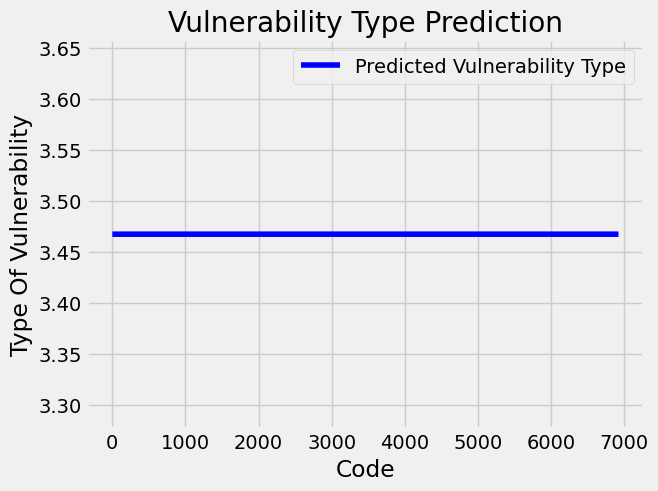

In [ ]:
from sklearn.metrics import classification_report
#print(predicted_label)
plot_predictions(test_df['Label'],predicted_label)